In [1]:
import matplotlib.pyplot as plt
import scipy as sp
import scipy.optimize
import numpy as np
import pandas as pd
import sympy as sym
from sympy.core.evaluate import evaluate
import math

In [2]:
forecastDays= 20
defaultZone = 'Italia'
defaultFunc = 'logistic'

In [3]:
func = {
    'quartic': lambda x,a,b,c,d,e: a*x**4 + b*x**3 +c*x**2 + d*x + e,
    'cubic': lambda x,a,b,c,d: a*x**3 + b*x**2 +c*x + d,
    'quadratic': lambda x,a,b,c: a*x**2 + b*x +c,
    'linear': lambda x,a,b: a*x + b,
    'power': lambda x,a,b,c: a*x**b + c,
    'powerNorm': lambda x,a,b: x**a + b,
    'powerSum': lambda x,a,b,c: (x+a)**b + c,
    'exp': lambda x,a,b,c: a*b**x + c,
    'expNorm': lambda x,a,b: a**x + b,
    'expGrowth': lambda x,a,b,c: a*b**(x/c), #a: f(0); b: growth factor; c: time to increase by a factor of b
    'expGrowth2': lambda x,a,b,c,d: a*b**(x/c)+d,
    'expGrowthNorm': lambda x,a,b: a**(x/b),
    'expGrowthNorm2': lambda x,a,b: a*b**x,
    'expGrowthNorm3': lambda x,a: a**x,
    'logistic': lambda x,a,b,c: c/(1+np.exp(-(x-b)/a)), #a: speed; b: peak; c: end
    'gompertz': lambda x,a,b,c: c*(np.exp(-np.log(c/b)*np.exp(-a*x))), #a: speed; b: start; c: end
}

In [4]:
values = {
    'Ospedalizzati':'totale_ospedalizzati',
    'Terapia int.':'terapia_intensiva',
    'Deceduti':'deceduti',
         }

In [5]:
def round_expr(expr, num_digits):
    return expr.xreplace({n : round(n, num_digits) for n in expr.atoms(sym.Number)})

In [6]:
def plotCurve(keys, zones=defaultZone, funcName=None, plotError=True):
    if not type(keys) is list:
        keys = [keys]
    if not type(zones) is list:
        zones = [zones]
        
    for zone in zones:
        for key in keys:
            if zone == 'Italia':
                data = pd.read_csv('https://github.com/pcm-dpc/COVID-19/raw/master/dati-andamento-nazionale/dpc-covid19-ita-andamento-nazionale.csv')
            else:
                data = pd.read_csv('https://github.com/pcm-dpc/COVID-19/raw/master/dati-regioni/dpc-covid19-ita-regioni.csv')
                data = data[data.denominazione_regione == zone]

            x = np.array(np.linspace(1+54, len(data)+54, len(data), dtype=float)) #start on 54th day of year
            xx = np.array(np.linspace(x[0], x[-1]+forecastDays, 50), dtype=float)

            y = {k:np.array(data[values[k]], dtype=float) for k in values}
            dates = np.array(data['data'])

            plt.plot(x, y[key], 'o', label="{}-{}".format(key, zone))

            if not funcName is None:
                try:
                    if funcName == 'logistic':
                        popt, pcov = sp.optimize.curve_fit(func[funcName], x, y[key], p0=[2,100,30000], maxfev=1000)
                        tex = '\\frac{{{}}}{{1+e^{{-(x-{})/{}}}}}'.format(round(popt[2],2),round(popt[1],2),round(popt[0],2))
                    else:
                        popt, pcov = sp.optimize.curve_fit(func[funcName], x, y[key])
                        #print(list(map(lambda v: '{0:.3f}'.format(v),popt)))

                        xs = sym.Symbol('x')
                        with evaluate(False):
                            #expr = func[funcName](sym.UnevaluatedExpr(xs),*(map(lambda v: round(v,2), popt)))
                            expr = func[funcName](xs,*(map(lambda v: round(v,2), popt)))
                        tex = sym.latex(expr).replace('$', '')
                        #tex = sym.latex(round_expr(func[funcName](xs,*popt), 3)).replace('$', '')

                    plt.plot(xx, func[funcName](xx, *popt), 'k')
                    if plotError:
                        errors = np.sqrt(np.diag(pcov))
                        nstd = 1.0
                        fit_up = popt + nstd * errors
                        fit_dw = popt - nstd * errors
                        fit_up_p = func[funcName](xx, *fit_up)
                        fit_dw_p = func[funcName](xx, *fit_dw)

                        plt.fill_between(xx, fit_up_p, fit_dw_p, alpha=.35, color="gray")

                except RuntimeError as e:
                    print(e)
                    tex = 'ERROR'

    if not funcName is None:
        plt.title('$f(x)= {}$\n{} - {}'.format(tex, dates[0], dates[-1]),fontsize=16)
    else:
        plt.title('{} - {}'.format(dates[0], dates[-1]),fontsize=16)
        
    plt.legend()
    plt.xlabel('Day number of year')

    plt.grid()
    plt.show()

# Plots

## Ospedalizzati

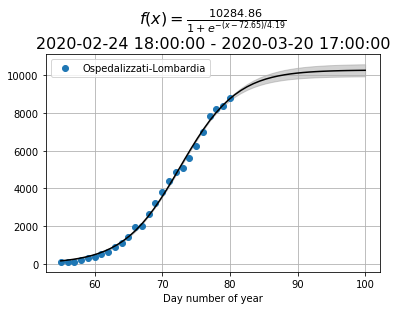

In [7]:
plotCurve('Ospedalizzati', 'Lombardia', funcName=defaultFunc)

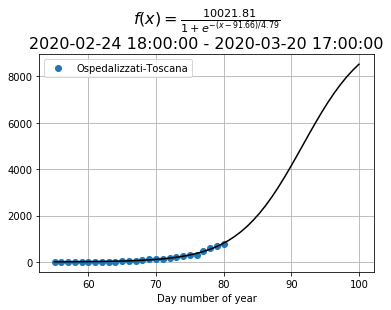

In [8]:
plotCurve('Ospedalizzati', 'Toscana', funcName=defaultFunc, plotError=False)

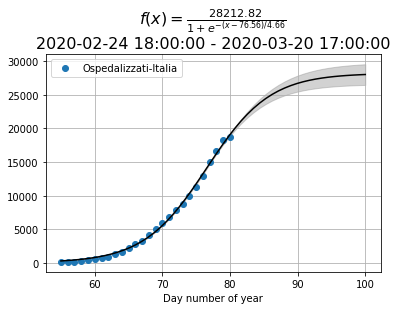

In [9]:
plotCurve('Ospedalizzati', funcName=defaultFunc)

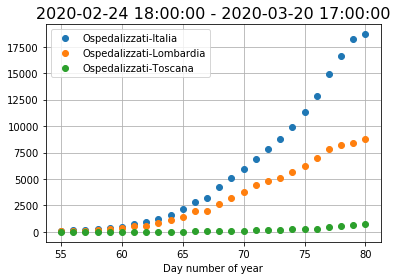

In [10]:
plotCurve('Ospedalizzati', ['Italia','Lombardia','Toscana'])

## Terapia intensiva

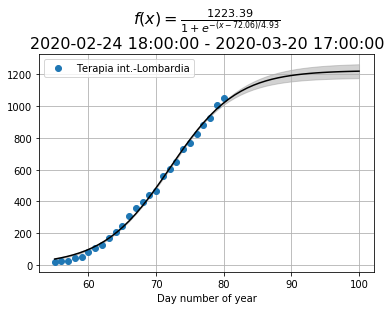

In [11]:
plotCurve('Terapia int.', 'Lombardia', funcName=defaultFunc)

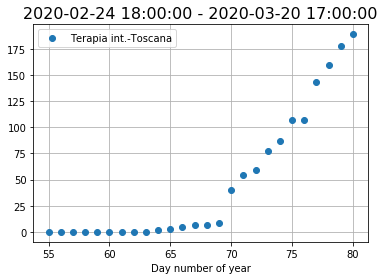

In [12]:
plotCurve('Terapia int.', 'Toscana')

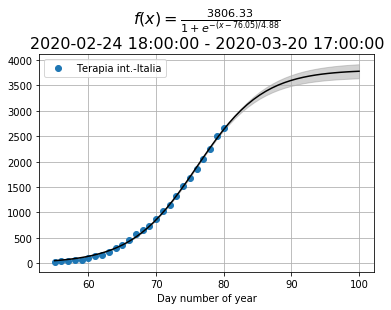

In [13]:
plotCurve('Terapia int.', funcName=defaultFunc)

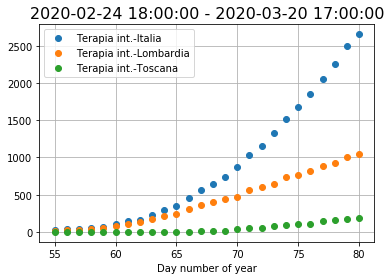

In [14]:
plotCurve('Terapia int.', ['Italia','Lombardia','Toscana'])

## Deceduti

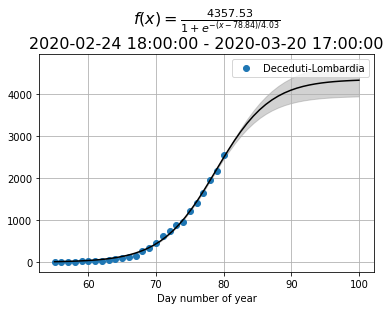

In [15]:
plotCurve('Deceduti', 'Lombardia', funcName=defaultFunc)

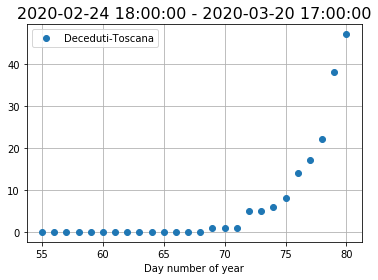

In [16]:
plotCurve('Deceduti', 'Toscana')

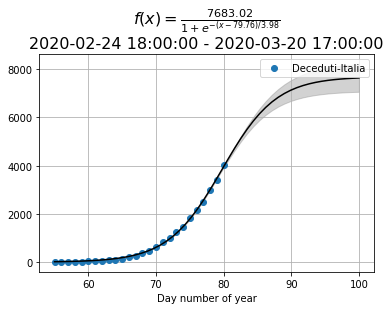

In [17]:
plotCurve('Deceduti', funcName=defaultFunc)

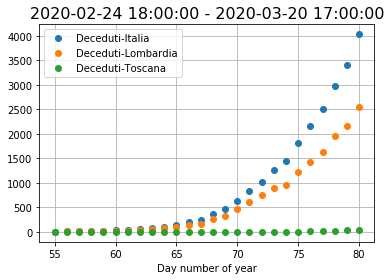

In [18]:
plotCurve('Deceduti', ['Italia','Lombardia','Toscana'])

# Compare

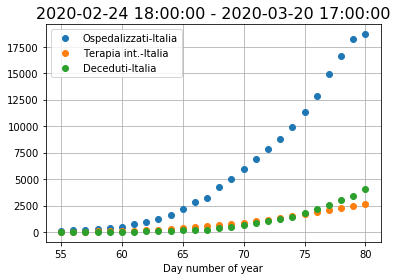

In [19]:
plotCurve(['Ospedalizzati','Terapia int.','Deceduti'], 'Italia')

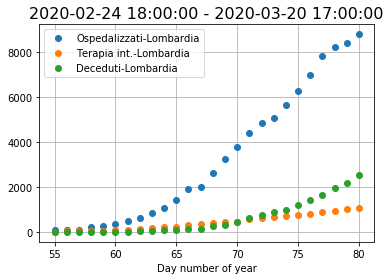

In [20]:
plotCurve(['Ospedalizzati','Terapia int.','Deceduti'], 'Lombardia')

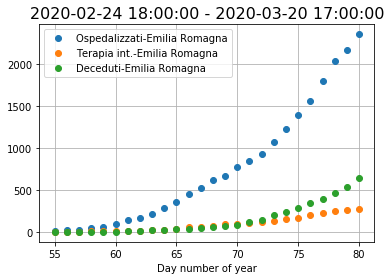

In [21]:
plotCurve(['Ospedalizzati','Terapia int.','Deceduti'], 'Emilia Romagna')

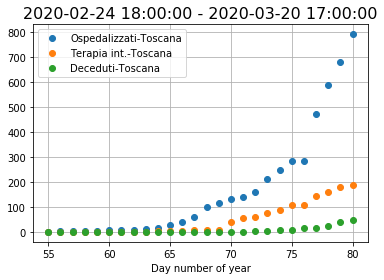

In [22]:
plotCurve(['Ospedalizzati','Terapia int.','Deceduti'], 'Toscana')

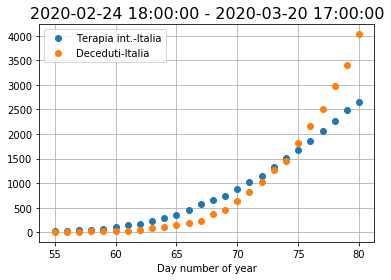

In [23]:
plotCurve(['Terapia int.','Deceduti'], 'Italia')

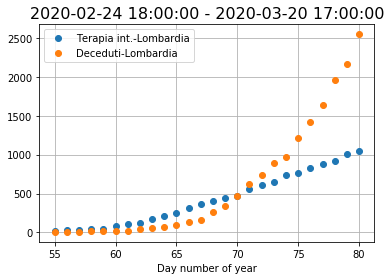

In [24]:
plotCurve(['Terapia int.','Deceduti'], 'Lombardia')

### References
* https://colab.research.google.com/drive/1EprvUCsrqeJOeuXHuQfY_iiO4Dw8NH5q?fbclid=IwAR0j2KjgX9ffrys4P0su036gmYSvDMAuCuwCUd1vNN7qlwmQvX8r0ZdpUpc#scrollTo=nZKHXDxcfegX
* https://avatorl.org/covid-19/?page=GrowthRateAndForecast
* https://github.com/pcm-dpc/COVID-19/
* https://towardsdatascience.com/covid-19-infection-in-italy-mathematical-models-and-predictions-7784b4d7dd8d
* https://www.youtube.com/watch?v=Kas0tIxDvrg&feature=youtu.be